Epoch [1/100], Loss: 0.0935
Epoch [2/100], Loss: 0.0842
Epoch [3/100], Loss: 0.0504
Epoch [4/100], Loss: 0.0409
Epoch [5/100], Loss: 0.0349
Epoch [6/100], Loss: 0.0297
Epoch [7/100], Loss: 0.0308
Epoch [8/100], Loss: 0.0252
Epoch [9/100], Loss: 0.0298
Epoch [10/100], Loss: 0.0208
Epoch [11/100], Loss: 0.0201
Epoch [12/100], Loss: 0.0169
Epoch [13/100], Loss: 0.0126
Epoch [14/100], Loss: 0.0154
Epoch [15/100], Loss: 0.0147
Epoch [16/100], Loss: 0.0108
Epoch [17/100], Loss: 0.0083
Epoch [18/100], Loss: 0.0156
Epoch [19/100], Loss: 0.0150
Epoch [20/100], Loss: 0.0084
Epoch [21/100], Loss: 0.0144
Epoch [22/100], Loss: 0.0116
Epoch [23/100], Loss: 0.0134
Epoch [24/100], Loss: 0.0102
Epoch [25/100], Loss: 0.0056
Epoch [26/100], Loss: 0.0094
Epoch [27/100], Loss: 0.0069
Epoch [28/100], Loss: 0.0117
Epoch [29/100], Loss: 0.0158
Epoch [30/100], Loss: 0.0111
Epoch [31/100], Loss: 0.0149
Epoch [32/100], Loss: 0.0122
Epoch [33/100], Loss: 0.0083
Epoch [34/100], Loss: 0.0071
Epoch [35/100], Loss: 0

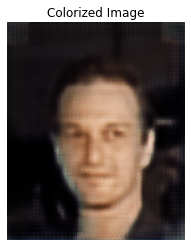

ValueError: axes don't match array

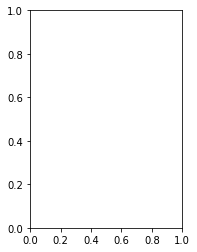

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

# Custom dataset loader
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        target = image.copy()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target  # Return grayscale as input, RGB as target

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define your dataset
dataset = CustomImageDataset("test1", transform=transform, target_transform=target_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# Autoencoder Network
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # Output: (16, size/2, size/2)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # Output: (32, size/4, size/4)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # Output: (64, size/28, size/28)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Ensuring output is in [0, 1]
)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        img, target = data
        # Forward pass
        output = model(img)
        loss = criterion(output, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    losses.append(loss.item())

#save model
torch.save(model.state_dict(), 'model.pth')


testimage = Image.open("000016.jpg").convert("L")
testimage = transform(testimage)
testresult = model(testimage.unsqueeze(0))

plt.imshow(np.transpose(testresult.squeeze().detach().numpy(), (1, 2, 0)))
plt.title('Colorized Image')
plt.axis('off')

plt.show()

# # Display the test result
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(testimage.squeeze(), cmap='gray')
# plt.title('Original Image')
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(testresult.detach().numpy(), (1, 2, 0)))
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()



# Plotting the training errors
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()
